# ``graspologic`` demo


<div>
<img src="https://raw.githubusercontent.com/bdpedigo/talks/main/docs/images/graspologic_svg.svg" width="400"/>
</div>

[![Paper shield](https://img.shields.io/badge/JMLR-Paper-red)](http://www.jmlr.org/papers/volume20/19-490/19-490.pdf)
[![PyPI version](https://img.shields.io/pypi/v/graspologic.svg)](https://pypi.org/project/graspologic/)
[![Downloads shield](https://pepy.tech/badge/graspologic)](https://pepy.tech/project/graspologic)
![graspologic CI](https://github.com/microsoft/graspologic/workflows/graspologic%20CI/badge.svg)
[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

### [Documentation](https://microsoft.github.io/graspologic/latest/)

### [GitHub](https://github.com/microsoft/graspologic)

### Table of contents
* [Background](#background)
* [Network embedding](#network-embedding)
  * [Why embed networks?](#why-embed)
  * [Embedding in ``graspologic``](#embed-graspologic)
  * [Examining an embedding](#examine-embed)
* [Network models](#network-models)
* [Hypothesis testing](#hypothesis-testing) 
* [Graph matching](#graph-matching)
  * [Graph matching problem](#graph-matching-problem)
  * [Solving graph matching](#solving-graph-matching)
  * [Graph matching with ``graspologic``](#graph-match-graspologic)
  * [Apply to some connectome data](#graph-matching-connectome)
  * [Incorporating known labels](#graph-matching-labels)
  * [Incorporating known pairs](#graph-matching-seeds)




In [1]:
import time

start_time = time.time()

## Background

``graspologic`` is a Python package for doing statistical/machine learning analyses on 
network data.

If you see places where the API could be improved, better documented, or features that 
are missing which would be helpful for your research, please let me know! 

In [2]:
!pip install graspologic

In [3]:
import graspologic

graspologic.__version__

'3.1.0'

## Loading some data

For these examples I'll use the recently published connectome of a *Drosophila* larva brain (paper [here](https://www.science.org/doi/10.1126/science.add9330)).

In [4]:
import pandas as pd

edges = pd.read_csv(
    "https://raw.githubusercontent.com/neurodata/neuropull/main/data/maggot_brain/edgelist.csv.gz"
)
edges.query("source != target", inplace=True)
edges[["source", "target", "weight"]]

,source,target,weight
0,29,2506050,1
1,29,3347834,4
2,29,3522293,4
3,29,3886356,3
4,29,3890028,1
...,...,...,...
110672,21591317,17729088,4
110673,21591317,17777259,1
110674,21591317,20278329,1
110675,21591317,20443420,1


In [5]:
nodes = pd.read_csv(
    "https://raw.githubusercontent.com/neurodata/neuropull/main/data/maggot_brain/nodes.csv.gz",
    index_col=0,
)
nodes[["side", "pair"]]

,side,pair
node_id,,
2206279,left,2
2216445,left,5
2215247,left,7
10241716,left,8
2216131,left,11
...,...,...
8978117,right,1641
8957325,right,1642
6978516,right,1643


Here, I just extract an 
[adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) from this data.

In [6]:
def edges_to_adjacency(edges, source_index, target_index=None):
    if target_index is None:
        target_index = source_index
    adjacency = (
        pd.crosstab(edges["source"], edges["target"], edges["weight"], aggfunc="sum")
        .reindex(index=source_index, columns=target_index)
        .fillna(0)
    )
    adjacency.index.name = "source"
    adjacency.columns.name = "target"
    return adjacency


adjacency = edges_to_adjacency(edges, nodes.index).values
adjacency

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Below, we can plot the adjacency matrix and make sure it's not all 0s.

(<Axes: >, <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x140162ad0>)

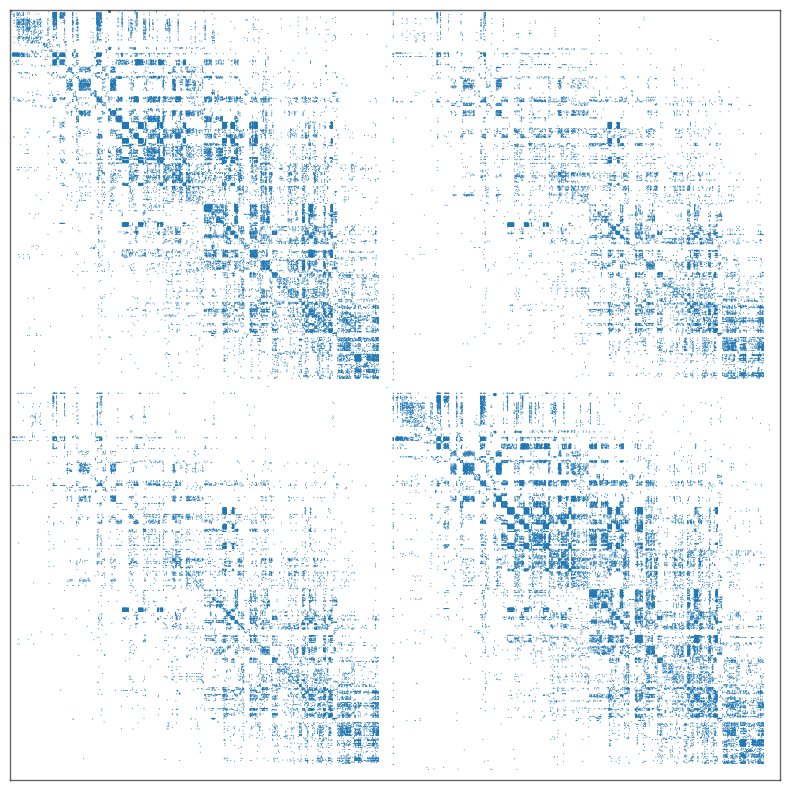

In [7]:
from graspologic.plot import adjplot

adjplot(adjacency, plot_type="scattermap", sizes=(0.5, 0.5))

## Network embedding <a class="anchor" id="embedding"></a>

Generally speaking, an **embedding** refers to some technique which takes a network (or
networks as we'll see later) and converts it to a representation in some vector space.

### Why embed networks? <a class="anchor" id="why-embed"></a>
- Embeddings can be useful for creating visualizations of networks. 
- Embeddings allow us to use a wide range of general machine learning techniques and
  make them applicable for networks.
- Embedding networks can be viewed as fitting the parameters of statistical models, 
  for example, a random dot product graph.

### Embedding in ``graspologic`` <a class="anchor" id="embed-graspologic"></a>
In `graspologic`, an example of this functionality is implemented under the `AdjacencySpectralEmbed` 
estimator class. There are a few extra bells and whistles, but the core algorithm is essentially SVD of the adjacency matrix. Note that this
algorithm also works well for weighted networks, but we lose some of the interpretation
of the approximation matrix as a matrix of probabilities.

In [8]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()

X, Y = ase.fit_transform(adjacency)

/Users/bpedigo/JHU_code/graspologic-demo/.venv/lib/python3.10/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


The warning above arises because there are some nodes in the network which don't connect to the bulk. This tends to distort many embedding (and other) algorithms. Thankfully, it is easy to identify and remove these nodes from the network.

In [9]:
from graspologic.utils import largest_connected_component

adjacency_lcc, lcc_indices = largest_connected_component(adjacency, return_inds=True)
nodes_lcc = nodes.iloc[lcc_indices]

X, Y = ase.fit_transform(adjacency_lcc)

`ase.fit_transform()` returns a tuple `(X, Y)` if the graph is directed. Otherwise, it
just returns `X`.

### Examining an embedding <a class="anchor" id="examine-embed"></a>

For plotting (and some of the tools we'll use later), it's helpful to have a vector
of labels indicating some broad neuron categories.

![](https://raw.githubusercontent.com/neurodata/bilateral-connectome/main/docs/images/Figure1-cell-classes.png)

In [10]:
labels = nodes_lcc["super_class"].values
labels

array(['sensory', 'sensory', 'sensory', ..., 'sensory', 'sensory',
       'sensory'], dtype=object)

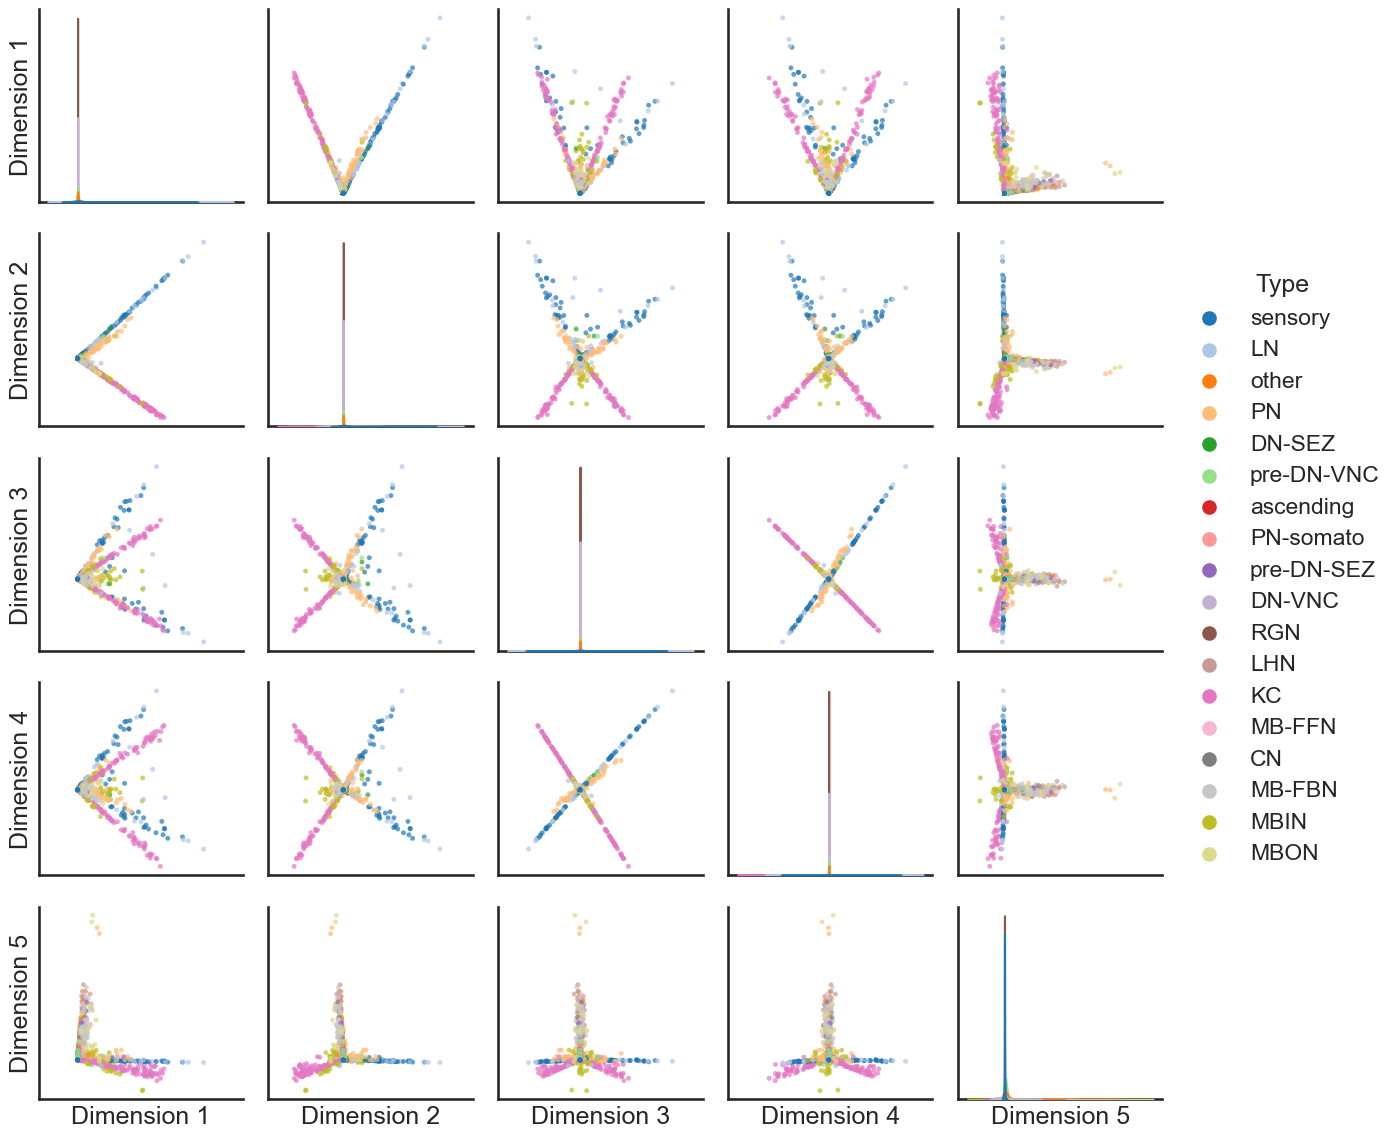

In [11]:
from graspologic.plot import pairplot

pairplot(X, labels=labels, palette="tab20")

<!-- For spectral methods on weighted networks, we often find it useful to do an operation 
called "pass-to-ranks." This essentially ranks each edge from smallest to largest weight,
then replaces the edge weight by a normalized version of the rank. It has the effect of
putting edges closer to the same scale. -->

For some applications, we don't care about having a separate representation for each 
node in terms of its inputs and outputs. We can simply concatenate the "out" and "in" 
representations. You can do this yourself, or we can specify this behavior in `graspologic`.

In [13]:
Z = AdjacencySpectralEmbed(concat=True).fit_transform(adjacency_lcc)
Z.shape

(2952, 10)

We can also embed a matrix in sparse format, which will usually be faster for sparse 
networks with more than a small number of nodes.

In [14]:
from scipy.sparse import csr_array

Z = AdjacencySpectralEmbed(concat=True).fit_transform(csr_array(adjacency_lcc))
Z.shape

(2952, 10)

More information on networks embedding in ``graspologic`` are available as [tutorials](https://microsoft.github.io/graspologic/latest/tutorials/index.html#embedding), 
and [API reference documentation](https://microsoft.github.io/graspologic/latest/reference/reference/embed.html).
You might also be interested in a [recent paper](https://www.annualreviews.org/doi/abs/10.1146/annurev-statistics-042720-023234) describing these methods in more detail
and their application to connectome data.


## Network models <a class="anchor" id="network-models"></a>

``graspologic`` contains functionality for fitting and sampling from several network 
statistical models. For instance, a [**stochastic block model (SBM)**
](https://en.wikipedia.org/wiki/Stochastic_block_model)
is a popular statistical model of networks. Put simply, this model treats the
probability of an edge occurring between node $i$ and node $j$ as purely a function of
the *communities* or *groups* that node $i$ and $j$ belong to. Therefore, this model
is parameterized by:

   1. An assignment of each node in the network to a group. Note that this assignment
      can be considered to be deterministic or random, depending on the specific
      framing of the model one wants to use.
   2. A set of group-to-group connection probabilities


<div>
<img src="https://raw.githubusercontent.com/neurodata/bilateral-connectome/main/results/figs/sbm_unmatched_test/sbm_explain.png" width=600>
</div>


> **Details:** Let $n$ be the number of nodes, and $K$ be the number of groups in an SBM. For a
network $A$ sampled from an SBM: $$ A \sim SBM(B, \tau)$$ We say that for all $(i,j), i \neq j$, with $i$ and $j$ both running
from $1 ... n$ the probability of edge $(i,j)$ occurring is: $$ P[A_{ij} = 1] = P_{ij} = B_{\tau_i, \tau_j} $$
where $B \in [0,1]^{K \times K}$ is a matrix of group-to-group connection
probabilities and $\tau \in \{1...K\}^n$ is a vector of node-to-group assignments.
Note that here we are assuming $\tau$ is a fixed vector of assignments, though other
formulations of the SBM allow these assignments to themselves come from a categorical
distribution.





In [15]:
from graspologic.models import SBMEstimator

estimator = SBMEstimator(directed=True, loops=True)

Currently, we have implementations for these models for *unweighted* networks. It's
possible to post-hoc put distributions of edge weights on these connections, or pull
from an empirical distribution of edge weights.

For now, we'll just work with the unweighted version of the adjacency matrix.

The other argument is a vector of labels denoting the mapping from each node ($i$-th
index the vector) to its category (the element in the $i$-th position).

In [16]:
from graspologic.utils import binarize

estimator.fit(binarize(adjacency_lcc), y=labels)

SBMEstimator(loops=True)

We can look at the matrix of group-to-group connection probabilities that were fit.

<Axes: >

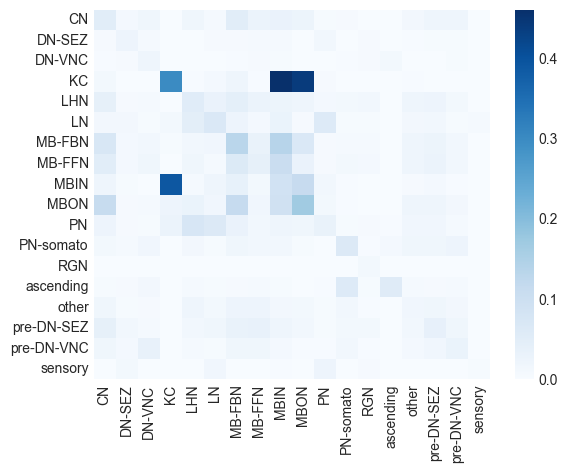

In [17]:
import numpy as np
import seaborn as sns

block_probabilities = pd.DataFrame(
    estimator.block_p_, index=np.unique(labels), columns=np.unique(labels)
)

sns.heatmap(block_probabilities, cmap="Blues")

We can also sample new networks from the model. This can be very useful for hypothesis
testing frameworks using null models, for instance.

(<Axes: >, <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x147825b10>)

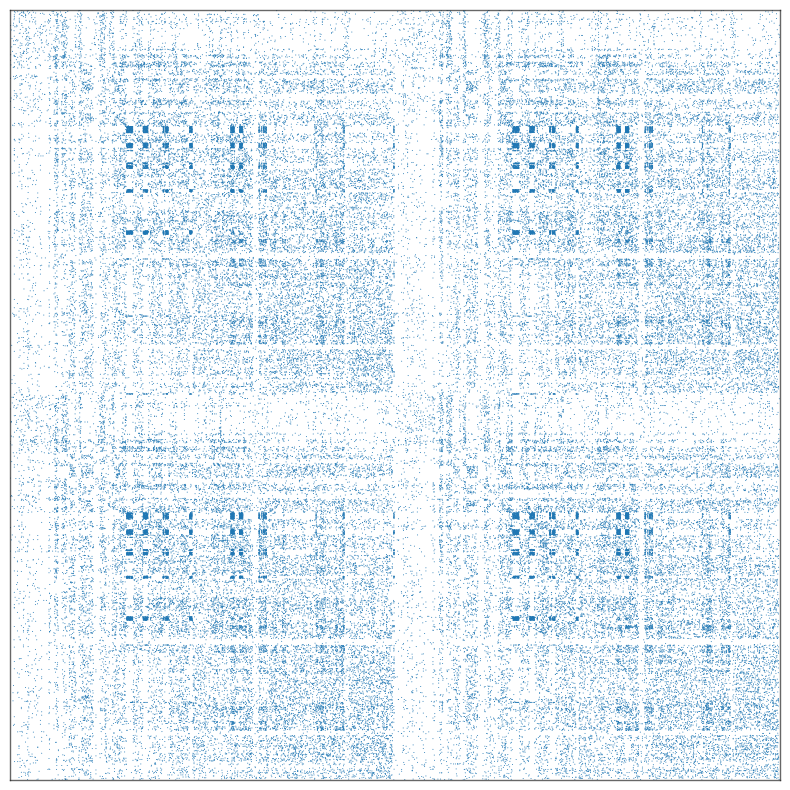

In [18]:
sampled_adjacency = estimator.sample()[0]

adjplot(sampled_adjacency, plot_type="scattermap", sizes=(0.5, 0.5))

We can also use the estimator object to ask about the log-likelihood of the network we
have given the model parameters we estimated.

In [19]:
print(estimator.score(binarize(adjacency_lcc)))

-491643.91736317927


More information on statistical models are available as a [tutorial](https://microsoft.github.io/graspologic/latest/tutorials/models/models.html), and as [API
reference documentation](https://microsoft.github.io/graspologic/latest/reference/reference/models.html).

## Hypothesis testing <a class="anchor" id="hypothesis-testing"></a>

Using a network model can also be helpful for statistical comparison. For the 
SBM, we can, for instance, compare the group-to-group
connection probability matrices, $B$,  for the left and right hemispheres.


> **Details:** We are interested in testing:$$H_0: B^{(L)} = B^{(R)}, \quad H_A: B^{(L)} \neq B^{(R)}$$ Thus, we are interested in comparing all $K^2$ probabilities between the SBM models for the left and right hemispheres. The hypothesis test above can be decomposed into $K^2$ independent hypotheses. $B^{(L)}$ and $B^{(R)}$ are both $K \times K$ matrices, where each element $b_{kl}$ represents the probability of a connection from a neuron in group $k$ to one in group $l$. We also know that group $k$ for the left network corresponds with group $k$ for the right. In other words, the *groups* are matched. Thus, we are interested in testing, for $k, l$ both running from $1...K$: $$H_0: B_{kl}^{(L)} = B_{kl}^{(R)},
\quad H_A: B_{kl}^{(L)} \neq B_{kl}^{(R)}$$

To run this comparison, we'll first split the network into the induced subgraphs for the left and right hemisphere nodes.

In [20]:
left_nodes = nodes_lcc.query("side == 'left'")
right_nodes = nodes_lcc.query("side == 'right'")

left_adjacency = edges_to_adjacency(edges, left_nodes.index, left_nodes.index).values
right_adjacency = edges_to_adjacency(edges, right_nodes.index, right_nodes.index).values

left_labels = left_nodes["super_class"].values
right_labels = right_nodes["super_class"].values

Then, running the hypothesis test described above is simple using the ``group_connection_test``
function.

In [21]:
from graspologic.inference import group_connection_test

stat, pvalue, misc = group_connection_test(
    left_adjacency, right_adjacency, left_labels, right_labels
)

print(f"p-value: {pvalue:.3g}")

/Users/bpedigo/JHU_code/graspologic-demo/.venv/lib/python3.10/site-packages/graspologic/inference/group_connection_test.py:369: UserWarning: This test assumes that the networks are unweighted, but one or both adjacency matrices are weighted.Test will be run on the binarized version of these adjacency matrices.
  warnings.warn(msg)


p-value: 0.000565


We see that according to the model assumptions above, there is evidence to believe the 
left and right hemispheres are different. We can further examine the constituent p-values
for each test of left/right connection probability to get a sense of where this difference
might be.

In [22]:
misc["corrected_pvalues"]

target,CN,DN-SEZ,DN-VNC,KC,LHN,LN,MB-FBN,MB-FFN,MBIN,MBON,PN,PN-somato,RGN,ascending,other,pre-DN-SEZ,pre-DN-VNC,sensory
source,,,,,,,,,,,,,,,,,,
CN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.00000,NaN
DN-SEZ,1.000000,1.0,1.0,NaN,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0
DN-VNC,1.000000,1.0,1.0,NaN,1.000000,1.0,1.000000,1.0,1.0,NaN,1.0,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0
KC,0.155539,1.0,NaN,0.021503,1.000000,1.0,0.097526,1.0,1.0,0.859585,1.0,1.000000,NaN,NaN,1.000000,1.0,1.00000,NaN
LHN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,0.295510,1.0,1.00000,NaN
LN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,NaN,0.771082,1.0,1.00000,1.0
MB-FBN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,NaN,1.000000,1.0,1.00000,NaN
MB-FFN,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,NaN,1.000000,1.0,1.00000,NaN
MBIN,1.000000,NaN,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,NaN,NaN,1.000000,1.0,1.00000,NaN


<Axes: xlabel='target', ylabel='source'>

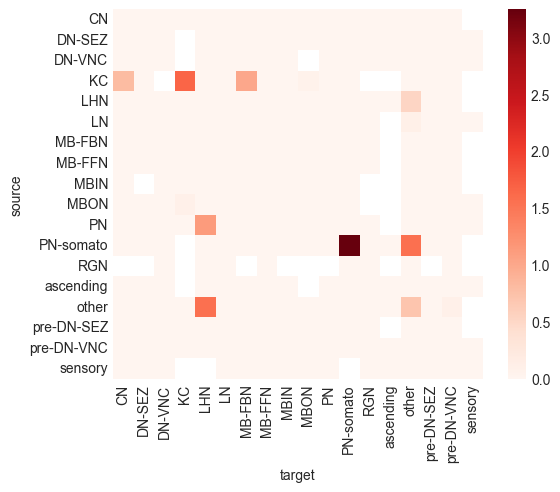

In [23]:
sns.heatmap(-np.log10(misc["corrected_pvalues"]), square=True, cmap="Reds")

More information on the hypothesis testing tools is available as [tutorials](https://microsoft.github.io/graspologic/latest/tutorials/index.html#inference) and [API reference](https://microsoft.github.io/graspologic/latest/reference/reference/inference.html). You may also be interested in our [recent application of some of these tools to the maggot connectome](https://elifesciences.org/articles/83739).

## Graph matching <a class="anchor" id="graph-matching"></a>

Given two networks, **graph matching** is the problem of inferring a 1-to-1 correspondence (matching) of the
nodes in the two. This can of course be useful in connectomics, where for instance we 
might want to match neurons between datasets (or subsets of a dataset, like two brain hemispheres)
on the basis of the connectivity we observed.

To start to understand graph matching, we first need to understand permutations and 
permutation matrices. A [**permutation**](https://en.wikipedia.org/wiki/Permutation) can be thought of as a
specific ordering or arrangement of some number of objects. 

<!-- If we fix the ordering of one set of objects (say, nodes in $A$), then we can also represent matchings of the two sets of objects as simple permutations of the second set (say, nodes in $B$). -->

Note that there are $n!$ permutations of $n$ objects - so guess-and-check blows up really fast.

Permutations, for us, will be represented by [**permutation matrices**](https://en.wikipedia.org/wiki/Permutation_matrix).
A permutation matrix is $n \times n$, with all zeros except for $n$ 1s. More specifically, each row and column has exactly one 1 in it. Let's look at
what a permutation matrix times a vector looks like.


<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Permutation_matrix%3B_P_%2A_column.svg" width="200"/>
</div>

A permutation matrix multiplied by a vector. The red elements of the matrix indicate the 
1s. Image from [Wikipedia](https://en.wikipedia.org/wiki/Permutation_matrix).


So, we see that if we look at the permutation matrix, the *row index* represents the 
index of the new position of object $i$. The *column index* represents the original
position of an object. So, if we have a 1 at position $(1, 4)$, that means the first
object was the fourth object in the original arrangement.

Note that this also works for matrices: each column of a matrix $A$ would be permuted
the same way as the vector in the example above. So, we can think of 

$$PA$$

as permuting the *rows* of the matrix $A$.

Note that post-multiplication by the matrix $P$ works the opposite way (try it out 
yourself if you don't see this, or refer to the Wikipedia article). For this reason, if
we wanted to permute the columns of $A$ in the same way, we'd have to do

$$AP^T$$

Thus, we can permute the rows *and* columns of the matrix $A$ via $PAP^T$

### Graph matching problem <a class="anchor" id="graph-matching-problem"></a>

Why do we care about permutations for the problem of [**graph matching**](https://en.wikipedia.org/wiki/Graph_matching)?
Graph matching refers to the problem of finding a mapping between the nodes of one graph ($A$)
and the nodes of some other graph, $B$. For now, consider the case where the two networks
have exactly the same number of nodes. Then, this problem amounts to finding a *permutation* 
of the nodes of one network with regard to the nodes of the other. Mathematically, we
can think of this as comparing $A$ vs. $P B P^T$. 

How can we measure the quality of this alignment between two networks? One natural way to do this is via the Frobenius norm of the difference. 

$$e(P) = \|A - PBP^T\|_F$$

In words, what is this quantity $e(P)$ measuring with respect to the edges of two
unweighted networks?

We can use this same definition above for any type of network: unweighted or weighted, 
directed or undirected, with or without self-loops.

![](https://raw.githubusercontent.com/neurodata/bilateral-connectome/main/docs/images/network-matching-explanation.svg)

### Solving the graph matching problem <a class="anchor" id="solving-graph-matching"></a>

Many solutions for the problem above have been proposed - note that all of these which
can run efficiently for anything but the smallest networks are 
approximate solutions, and they tend to scale fairly poorly (mainly in the number of nodes)
I'm just going to focus on one family of algorithms based on the work of 
Vogelstein et al. *PLOS One* (2015).

> **Details:** We have a discrete problem, but we'd like to use continuous optimization tools where we can take gradients. To make this possible, the Fast Approximate Quadradic (FAQ) method first relaxes the constraint that $P$ be a permutation matrix. Via the Birkhoff-von Neumann theorem, it can be shown that the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of the permutation matrices is the set of [**doubly stochastic matrices**](https://en.wikipedia.org/wiki/Doubly_stochastic_matrix). A doubly stochastic matrix just has row and columns sums equal to 1, but does not necessarily have to have all nonzero elements equal to 1. This theorem is essentially saying that if I take a weighted average of any two permutation matrices, the row and columns sums of the result must be 1. It can be shown that minimizing our $e(P)$ above is equivalent to $$\min_P -\text{trace}(APB^T P^T)$$ Calling our doubly stochastic matrices $D$, we now have $$\min_D -\text{trace}(ADB^T D^T)$$ Given this relaxation, we can now take gradients in our space of matrices. I won't go into every detail, but the algorithm we end up using is 
roughly: 
> 1. Start with some initial position - note that this position is itself a doubly stochastic matrix.
> 2. Compute the gradient of the expression above with respect to $D$. This gives us our "step direction."
> 3. Compute a step size (how far to go in that direction in the space of matrices) by searching over the line between our current position and the one computed in 2.
> 4. Update our position based on 3.
> 5. Repeat 2.-4. until some convergence criterion is reached.
> 6. Project back to the set of permutation matrices.

### Graph matching with `graspologic` <a class="anchor" id="graph-match-graspologic"></a>

Thankfully, all of this is implemented in `graspologic`. Let's start by generating a random network (ER). We'll then make a permuted copy of itself.

In [24]:
from graspologic.match import graph_match
from graspologic.simulations import er_np

n = 20
p = 0.3

np.random.seed(1)
rng = np.random.default_rng(8888)

G1 = er_np(n=n, p=p)

node_shuffle_input = np.random.permutation(n)
G2 = G1[node_shuffle_input][:, node_shuffle_input]

print("Number of edge disagreements: ", np.sum(abs(G1 - G2)))

Number of edge disagreements:  168.0


<Axes: title={'center': 'Difference'}>

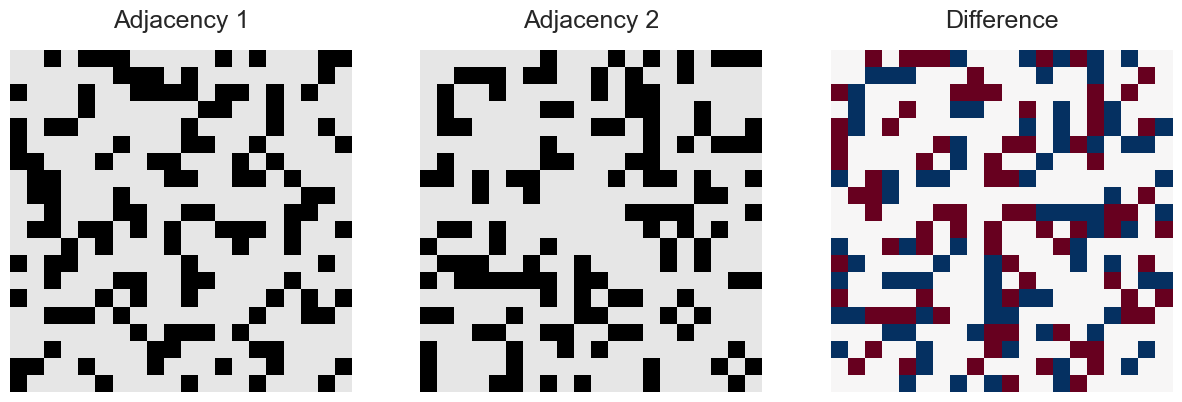

In [25]:
import matplotlib.pyplot as plt
from graspologic.plot import heatmap

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
heatmap(
    G1,
    cbar=False,
    title="Adjacency 1",
    ax=axs[0],
    cmap="binary",
    vmin=0.1,
    center=0.5,
    vmax=1,
)
heatmap(
    G2,
    cbar=False,
    title="Adjacency 2",
    ax=axs[1],
    cmap="binary",
    vmin=0.1,
    center=0.5,
    vmax=1,
)
heatmap(G1 - G2, cbar=False, title="Difference", ax=axs[2], center=0, vmin=-1, vmax=1)

Now, let's solve the graph matching problem.

In [26]:
_, perm_inds, _, _ = graph_match(G1, G2, rng=rng)
G2 = G2[perm_inds][:, perm_inds]
print("Number of edge disagreements: ", np.sum(abs(G1 - G2)))

Number of edge disagreements:  0.0


So, we've exactly recovered the correct permutation - note that this won't always be true.

### Apply to some connectome data <a class="anchor" id="graph-matching-connectome"></a>

In [27]:
left_permutation, right_permutation, score, misc = graph_match(
    left_adjacency, right_adjacency, rng=rng, verbose=3
)

[Pre-loop] Initializing
   [Pre-loop] Computing constant terms
   [Iteration: 1] Computing gradient
   [Iteration: 1] Solving assignment problem
   [Iteration: 1] Computing step size
   [Iteration: 2] Computing gradient
   [Iteration: 2] Solving assignment problem
   [Iteration: 2] Computing step size
   [Iteration: 3] Computing gradient
   [Iteration: 3] Solving assignment problem
   [Iteration: 3] Computing step size
   [Iteration: 4] Computing gradient
   [Iteration: 4] Solving assignment problem
   [Iteration: 4] Computing step size
   [Iteration: 5] Computing gradient
   [Iteration: 5] Solving assignment problem
   [Iteration: 5] Computing step size
   [Iteration: 6] Computing gradient
   [Iteration: 6] Solving assignment problem
   [Iteration: 6] Computing step size
   [Iteration: 7] Computing gradient
   [Iteration: 7] Solving assignment problem
   [Iteration: 7] Computing step size
   [Iteration: 8] Computing gradient
   [Iteration: 8] Solving assignment problem
   [Iteration: 

<Axes: title={'center': 'Difference'}>

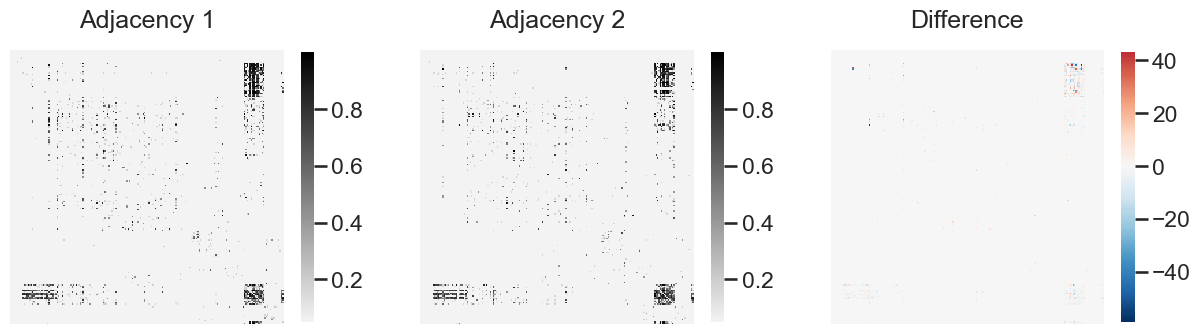

In [28]:
left_adjacency_permuted = left_adjacency[left_permutation][:, left_permutation]
right_adjacency_permuted = right_adjacency[right_permutation][:, right_permutation]

show_nodes = slice(0, 200)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

heatmap(
    left_adjacency_permuted[show_nodes][:, show_nodes],
    title="Adjacency 1",
    transform="simple-nonzero",
    ax=axs[0],
    cmap="binary",
    vmin=0.05,
    center=0.5,
)
heatmap(
    right_adjacency_permuted[show_nodes][:, show_nodes],
    title="Adjacency 2",
    transform="simple-nonzero",
    ax=axs[1],
    cmap="binary",
    vmin=0.05,
    center=0.5,
)
heatmap(
    left_adjacency_permuted[show_nodes][:, show_nodes]
    - right_adjacency_permuted[show_nodes][:, show_nodes],
    title="Difference",
    ax=axs[2],
    cmap="RdBu_r",
)

In [29]:
original_score = score  # saving for later
score

1000156.0

In [30]:
misc[0]

{'score': 1000156.0,
 'n_iter': 25,
 'convex_solution': array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'converged': True}

### Incorporating neuron labels <a class="anchor" id="graph-matching-labels"></a>

One piece of prior information we might want to use is some information about what
cell types or groups each neuron belongs to. We can incorporate this information as a 
"soft" constraint by encoding it in a similarity matrix. 

> **Details:** Below, I just create a matrix $S$ such that if two nodes $i$ and $j$ are
> in the same class, $S_{ij} = 1$, otherwise, $S_{ij} = 0$.

<Axes: >

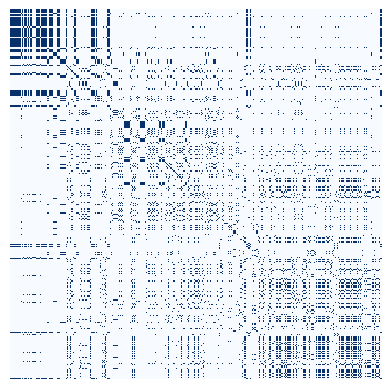

In [31]:
class_similarity = (
    left_nodes["super_class"].values[:, None]
    == right_nodes["super_class"].values[None, :]
)

sns.heatmap(
    class_similarity,
    cmap="Blues",
    cbar=False,
    square=True,
    xticklabels=False,
    yticklabels=False,
)

We can add this information via an additional term in the optimization which 
encourages matched nodes to have a high value of this similarity matrix.

> **Details:** the new problem becomes $$\min_P \| A - P B P^T\|_F + tr(SP^T)$$

In [32]:
left_permutation, right_permutation, score, misc = graph_match(
    left_adjacency,
    right_adjacency,
    S=class_similarity,
    rng=rng,
    verbose=3,
)

[Pre-loop] Initializing
   [Pre-loop] Computing constant terms
   [Iteration: 1] Computing gradient
   [Iteration: 1] Solving assignment problem
   [Iteration: 1] Computing step size
   [Iteration: 2] Computing gradient
   [Iteration: 2] Solving assignment problem
   [Iteration: 2] Computing step size
   [Iteration: 3] Computing gradient
   [Iteration: 3] Solving assignment problem
   [Iteration: 3] Computing step size
   [Iteration: 4] Computing gradient
   [Iteration: 4] Solving assignment problem
   [Iteration: 4] Computing step size
   [Iteration: 5] Computing gradient
   [Iteration: 5] Solving assignment problem
   [Iteration: 5] Computing step size
   [Iteration: 6] Computing gradient
   [Iteration: 6] Solving assignment problem
   [Iteration: 6] Computing step size
   [Iteration: 7] Computing gradient
   [Iteration: 7] Solving assignment problem
   [Iteration: 7] Computing step size
   [Iteration: 8] Computing gradient
   [Iteration: 8] Solving assignment problem
   [Iteration: 

In [33]:
conn_score = score - class_similarity[left_permutation, right_permutation].sum()
print("Score without class similarity: ", original_score)
print("Score with class similarity: ", conn_score)

Score without class similarity:  1000156.0
Score with class similarity:  1052693.0


### Incorporating known pairings <a class="anchor" id="graph-matching-seeds"></a>

In [34]:
left_pn_nodes = left_nodes.query("(super_class == 'PN') & has_valid_pair")
right_pn_nodes = right_nodes.query("super_class == 'PN' & has_valid_pair")
left_kc_nodes = left_nodes.query("super_class == 'KC'").sample(frac=1)
right_kc_nodes = right_nodes.query("super_class == 'KC'").sample(frac=1)

Finding nodes which we'll use as "seed" known pairings for this example. These are neuron
matches which we believe in, and we'd like to use to improve our matching of the rest of
the network

In [35]:
left_pn_nodes = left_pn_nodes.sort_values("pair")
right_pn_nodes = right_pn_nodes.sort_values("pair")

assert (left_pn_nodes["pair"].values == right_pn_nodes["pair"].values).all()

partial_match = np.stack(
    (np.arange(len(left_pn_nodes)), np.arange(len(right_pn_nodes)))
).T
print(partial_match.shape)
partial_match

(103, 2)


array([[  0,   0],
       [  1,   1],
       [  2,   2],
       [  3,   3],
       [  4,   4],
       [  5,   5],
       [  6,   6],
       [  7,   7],
       [  8,   8],
       [  9,   9],
       [ 10,  10],
       [ 11,  11],
       [ 12,  12],
       [ 13,  13],
       [ 14,  14],
       [ 15,  15],
       [ 16,  16],
       [ 17,  17],
       [ 18,  18],
       [ 19,  19],
       [ 20,  20],
       [ 21,  21],
       [ 22,  22],
       [ 23,  23],
       [ 24,  24],
       [ 25,  25],
       [ 26,  26],
       [ 27,  27],
       [ 28,  28],
       [ 29,  29],
       [ 30,  30],
       [ 31,  31],
       [ 32,  32],
       [ 33,  33],
       [ 34,  34],
       [ 35,  35],
       [ 36,  36],
       [ 37,  37],
       [ 38,  38],
       [ 39,  39],
       [ 40,  40],
       [ 41,  41],
       [ 42,  42],
       [ 43,  43],
       [ 44,  44],
       [ 45,  45],
       [ 46,  46],
       [ 47,  47],
       [ 48,  48],
       [ 49,  49],
       [ 50,  50],
       [ 51,  51],
       [ 52,

In [36]:
left_index = np.concatenate((left_pn_nodes.index, left_kc_nodes.index))
right_index = np.concatenate((right_pn_nodes.index, right_kc_nodes.index))

left_subgraph_adjacency = edges_to_adjacency(edges, left_index, left_index).values
right_subgraph_adjacency = edges_to_adjacency(edges, right_index, right_index).values

<Axes: >

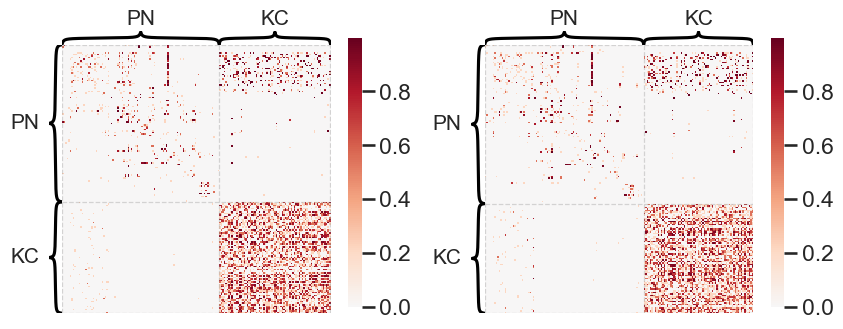

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

left_labels = left_nodes.loc[left_index, "super_class"].values
right_labels = right_nodes.loc[right_index, "super_class"].values

heatmap(
    left_subgraph_adjacency,
    transform="simple-nonzero",
    inner_hier_labels=left_labels,
    hier_label_fontsize=15,
    ax=axs[0],
)
heatmap(
    right_subgraph_adjacency,
    transform="simple-nonzero",
    inner_hier_labels=right_labels,
    hier_label_fontsize=15,
    ax=axs[1],
)

In [38]:
left_permutation, right_permutation, score, misc = graph_match(
    left_subgraph_adjacency, right_subgraph_adjacency
)
print("Score without seeds:", score)

left_permutation, right_permutation, score, misc = graph_match(
    left_subgraph_adjacency, right_subgraph_adjacency, partial_match=partial_match
)
print("Score with seeds:", score)

Score without seeds: 53956.0
Score with seeds: 56057.0


Documentation for the graph matching tools are available as [tutorials](https://microsoft.github.io/graspologic/latest/tutorials/index.html#matching) and [API reference](https://microsoft.github.io/graspologic/latest/reference/reference/match.html). You may also be interested in 
[our recent work](https://direct.mit.edu/netn/article/doi/10.1162/netn_a_00287/113527/Bisected-graph-matching-improves-automated-pairing) describing some of these tools in more detail and their application to connectome data.

## Fin

In [39]:
import datetime

elapsed = time.time() - start_time
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:01:31.141291
Completed at 2023-05-22 14:57:41.696742
